# Validation of distances between related Embeddings

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import util.util_validation as ut_val

### Parameters

In [2]:
cuda_device = 0
tsenecuda_venv = "/home/tgottwald/tsnecuda_venv/"

# untrained
# root_model = "./save/SupCE/untrained/SupCE_untrained_resnet18_lr_0.0_decay_0.0001_bsz_26_trial_0_noTraining/models/last.pth"

# cross validation:
# original data:
# root_model = "./save/SupCE/animals10/SupCE_animals10_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_baseline_cosine/models/ckpt_epoch_500.pth"
# diffused data:
# root_model = "./save/SupCE/animals10_diff_4000/SupCE_animals10_diff_4000_resnet18_lr_0.125_decay_0.0001_bsz_26_trial_0_4000_cosine/models/last.pth"

# supervised contrastive learning:
# with classes as positives and negatives
# original data:
# root_model = "./save/SupCon/animals10/SupCon_animals10_resnet18_lr_0.5_decay_0.0001_bsz_26_temp_0.1_trial_0_try2_cosine/models/last.pth"
# original and diffused data (with no augmentations):
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupCon_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"

# with one positive and other classes as negatives
# original and diffused data (with no augmentations):
# root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_noAug_cosine/models/last.pth"
# original and diffused data (with color augmentations):
root_model = "./save/SupCon/animals10_diff_-1+4000/SupConHybrid_animals10_diff_-1+4000_resnet18_lr_0.125_decay_0.0001_bsz_26_temp_0.1_trial_0_colorAug_cosine/models/last.pth"

dataset_1 = "animals10_diff_-1"
dataset_2 = "animals10_diff_4000"

aug_dict = {'aug': [], 'resizedCrop': [0.5, 1.0, 3/4, 4/3], 'horizontalFlip': 0.5, 'colorJitter': [0.8, 0.4, 0.4, 0.4, 0.4], 'grayscale': 0.2}


root_train_1, root_test_1 = ut_val.get_root_dataset(dataset_1)
root_train_2, root_test_2 = ut_val.get_root_dataset(dataset_2)

path_save, path_run_md, path_val_md_1, path_val_md_2, path_comb_md, path_comb, path_embeddings_1, path_embeddings_2, epoch = ut_val.get_paths_to_embeddings_and_run_md(root_model, dataset_1, dataset_2)

params = ut_val.read_parameters_from_run_md(path_run_md)

### Model and DataLoaders

In [3]:
if len(aug_dict['aug']) > 0:
    train_loader, val_loader = ut_val.set_dataloader(dataset_1, params, root_train_1, root_test_1, root_train_2, root_test_2, aug_dict)

    model = ut_val.set_model(root_model, params, len(val_loader.dataset.classes), cuda_device)

### Embeddings

In [4]:
with open(os.path.join(path_embeddings_1, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_test_1 = entry['data']
    class_labels_test = entry['labels']

with open(os.path.join(path_embeddings_2, "embedding_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_test_2 = entry['data']

if len(aug_dict['aug']) == 0:
    with open(os.path.join(path_embeddings_1, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_1 = entry['data']
        class_labels_train = entry['labels']

    with open(os.path.join(path_embeddings_2, "embedding_train"), 'rb') as f:
        entry = pickle.load(f, encoding='latin1')
        embedding_train_2 = entry['data']
else:
    embedding_aug_1, embedding_aug_2, class_labels_aug = ut_val.compute_diff_embeddings(model, val_loader, params, cuda_device)

### Investigate Distances

In [5]:
mean_dist, mean_dist_class, mean_dist_all = ut_val.compute_mean_distance(embedding_test_1, embedding_test_2, class_labels_test)
print("Mean Distances:")
print(f"Related Images: {mean_dist:.4f}")
print(f"Mean for same Class: {mean_dist_class:.4f}")
print(f"All versus all: {mean_dist_all:.4f}")

100%|██████████| 5236/5236 [00:37<00:00, 141.41it/s]

Mean Distances:
Related Images: 0.0012
Mean for same Class: 0.3221
All versus all: 0.3530


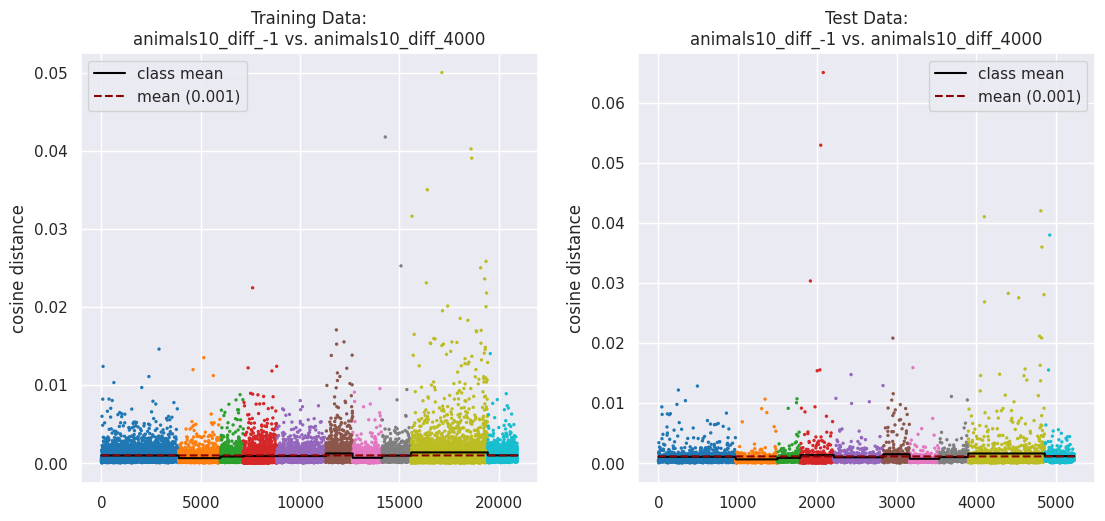

In [6]:
if len(aug_dict['aug']) == 0:
    ut_val.plot_distances(dataset_1, dataset_2, embedding_train_1, embedding_train_2, class_labels_train, embedding_test_1, embedding_test_2, class_labels_test)
else:
    ut_val.plot_aug_distances(dataset_1, dataset_2, embedding_test_1, embedding_test_2, embedding_aug_1, embedding_aug_2, class_labels_test, aug_dict['aug'])

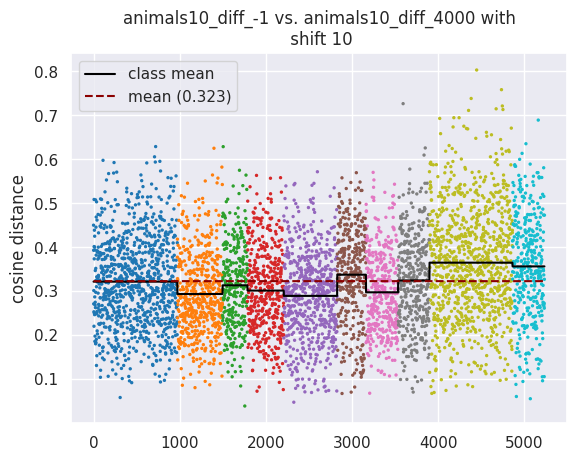

In [7]:
ut_val.plot_roll_distances(shifts=10, dataset_1=dataset_1, dataset_2=dataset_2, embedding_1=embedding_test_1, embedding_2=embedding_test_2, class_labels=class_labels_test)

### t-SNE of two Datasets

In [13]:
path_tsne_save = os.path.join(path_comb, f"{epoch}")

sample_size = 10

tsenecuda_venv_lib64 = os.path.join(tsenecuda_venv, "lib64")
tsenecuda_venv_interpreter = os.path.join(tsenecuda_venv, "bin/python")

In [22]:
!CUDA_VISIBLE_DEVICES={cuda_device} LD_LIBRARY_PATH={tsenecuda_venv_lib64} {tsenecuda_venv_interpreter} compute_tsne.py --path {path_embeddings_1} --path_second {path_embeddings_2} --path_save {path_tsne_save}

Data split train
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding
Data split test
load feature embedding
load second feature embedding
compute t-SNE embedding
writ t-SNE embedding


In [23]:
with open(os.path.join(path_tsne_save, "embedding_tSNE_train"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_train = entry['data']
    labels_train = entry['labels']
N_train = len(labels_train)//2
num_classes = len(set(labels_train))
df_train = pd.DataFrame.from_dict({'x': embedding_tSNE_train[:,0], 'y': embedding_tSNE_train[:,1], 'label': labels_train,
                                   'dataset': N_train*[dataset_1]+N_train*[dataset_2], 'dataset_label': N_train*[0]+N_train*[1]})

with open(os.path.join(path_tsne_save, "embedding_tSNE_test"), 'rb') as f:
    entry = pickle.load(f, encoding='latin1')
    embedding_tSNE_test = entry['data']
    labels_test = entry['labels']
N_test = len(labels_test)//2
df_test = pd.DataFrame.from_dict({'x': embedding_tSNE_test[:,0], 'y': embedding_tSNE_test[:,1], 'label': labels_test,
                                   'dataset': N_test*[dataset_1]+N_test*[dataset_2], 'dataset_label': N_test*[0]+N_test*[1]})

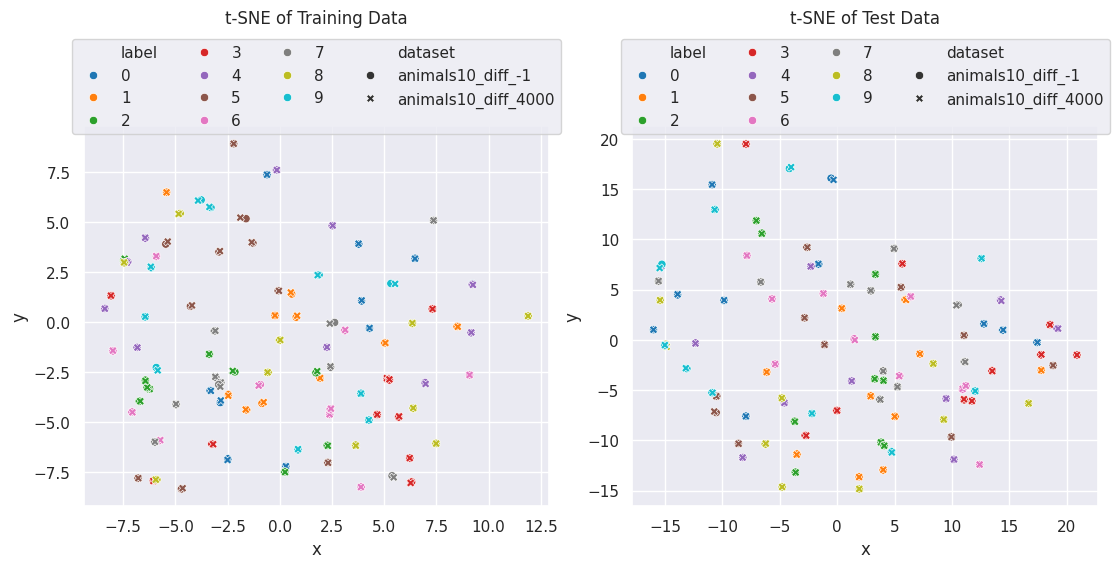

In [71]:
seaborn.set_theme(style="darkgrid")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))
fig.tight_layout(w_pad=2)

df_train_sample = df_train[df_train.dataset_label == 0].groupby('label').sample(sample_size)
indices_train = np.array([[idx, idx+N_train] for idx in df_train_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_train.loc[indices_train], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[0])
axs[0].set_title("t-SNE of Training Data", y=1.25)
axs[0].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))

df_test_sample = df_test[df_test.dataset_label == 0].groupby('label').sample(sample_size)
indices_test = np.array([[idx, idx+N_test] for idx in df_test_sample.index]).reshape(-1)
seaborn.scatterplot(data=df_test.loc[indices_test], x='x', y='y', hue='label', style='dataset', palette='tab10', ax=axs[1])
axs[1].set_title("t-SNE of Test Data", y=1.25)
axs[1].legend(loc="upper center", ncols=4, bbox_to_anchor=(0.5,1.25))